# PUBG: Leveraging Causal Inference to Guide Game Design Decisions
**by Siraj Hatoum**

## Introduction

### Project Context

Player Unknown's Battleground (PUBG) is an online multiplayer first-person shooter, released in 2017 on PC and Xbox. Many attribute PUBG with popularizing the Battle Royale genre in gaming, a genre that grew to become massively successful with games such as Fortnite, Apex Legends, and Call of Duty Warfare adopting many of its core mechanics. 

In PUBG up to 100 players are dropped into a spacious map with the sole objective of being the last suvivor. Players search the environment for useful items to improve their chances of survival, such as weapons, armor, boost items, and healing items. The game encourges scurmishes between opposing players and heightens the competition by progressively shrinking the map, pushing players into increasingly frequent encounters. The game ends when all opposing players are down and the last player standing is pronounced the winner. Depending on the match type, PUBG can be played individually or in teams of up to 4 players.

Hoping to capatilize on the popularity of the game and expand its reach to a wider player base, PUBG licensed the development of a mobile port that was released in 2018. Aside from developing a lighter version of the game that could run smoothly on most smartphones, the mobile port incorporated gameplay changes to make the game more palatable to a casual gaming audience, for example, moving the player's perspective from first-person to third-person.

Similar game design decisions are increasingly common in the industry as publishers attempt to monetize their traditionally console and PC bound games and intellectual property in a larger and more accessible mobile market. This report will use PUBG (non-mobile) in-game player data and causal inference methods to support a hypothetical mobile port design decision, outlined below.

### Project Motivation

PUBG mobile's game design lead believes that a major obstacle to adoption in the mobile gaming market is the time required to complete a single match. While very few players survive up to the end of the match by design, the team believes that the time commitment required for a player to potentially win a single match will be off-putting to mobile gamers, who are often seeking a quick diversion whether they are in between tasks, in transit, or on a quick break. Given the main selling points of PUBG, the team is limited by the number of features they can change as they do not want to "water down" the experience, losing the games unique value proposition and angering their existing player base.

Based on these constraints the designers identified 5 changes (treatments) that could be applied to reduce match duration (outcome) without significantly affecting other gameplay mechanics. These are: improve aim_assist, decrease boost item drop rate, decrease heal item drop rate, increase weapon drop rate, or increase damage modifiers. Given the short development window and cost of testing, the team does not have the resources to test all 5 of these changes seperately. It is the aim of this report to perform a causal analysis to recommend which of the 5 treatments is likely to achieve the desire change with minimal variation to existing gameplay.

## Data

### Data Source

Data used in this analysis was pulled from a [Kaggle competition data set](https://www.kaggle.com/c/pubg-finish-placement-prediction/data?select=test_V2.csv) on in-match player stats published by PUBG to predict the placement of competing players.

### Data Load

In [1]:
data_dir = "data/"

In [2]:
import pandas as pd

data = pd.read_csv(data_dir+'test_V2.csv')

In [3]:
# Filter out custom match types to focus to minimize outliers

standard_matchTypes = ["solo", "duo", "squad", "solo-fpp", "duo-fpp", "squad-fpp"]
matchType_filter = [matchType in standard_matchTypes for matchType in data.matchType.values]
data= data[matchType_filter]
data.shape

(1924336, 28)

In [4]:
pd.set_option('display.max_columns', None)
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


### Data Cleaning & Prep

In [5]:
data.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [6]:
# Aggregate individual player stats by match id

match_data = data.groupby(['matchId']).agg({
    
    'Id':pd.Series.nunique,        # Number of players in match
    'groupId': pd.Series.nunique,  # Number of teams in match
    'assists': [sum],              # Total assisted kills during match
    'boosts': [sum],               # Number of boost items consumed during match
    'damageDealt': [sum],          # Total damage dealt during match
    'headshotKills': [sum],        # Total headshot kills in game
    'heals': [sum],                # Number of healing items used in match
    'killPoints': ['mean', 'std'], # Average and standard deviation of players' kill ranking
    'killStreaks': ['max', 'std'], # Highest and standard deviation of player's highest kill streak during match
    'kills': ['sum', 'max', 'std'],# Maximum number of kills by a player and standard deviation between
    'matchDuration': ['mean'],     # Match duraion in seconds
    'revives': [sum],              # Total players revived in match
    'weaponsAcquired': [sum]       # Total number of weapons acquired during match 
})

In [7]:
match_data.columns=[
    'player_num',         # Confounding variable that impacts most other variables
    'team_num',           # Confounding variable that is impacted by player_num and match type impacing match duration
    'assists_tot',        # Confounding variable impacted by match type and team_num that can impact match duration
    'boosts_tot',         # Potential treatment variable to impact match duration
    'damageDealt_tot',    # Potential treatment variable to impact match duration
    'headshotKills_tot',  # Potential treatment variable to impact match duration
    'heals_tot',          # Potential treatment variable to impact match duration
    'killPoints_pp',      # Rough measure of average player skill in match, impacts match duration
    'killPoints_std',     # Rough measure of variation in player skill in match, impacts match duration
    'killStreak_max',     # Rough measure of best player performance, impacts match duration
    'killStreak_std',     # Rough measure of variation in player performnce, impacts match duration
    'kills_tot',          # Normalizing variable required to genrate an aim assist treatment variable
    'kills_max',          # Rough measure of single player dominance in match, impacts match duration
    'kills_std',          # Rough measure of variation of single player impact on match, impacts match duration
    'matchDuration',      # Outcome variable
    'revives_tot',        # Confounding variable impacted by match type and team number, impacts match duration
    'weaponAcquired_tot'  # Potential treatment variable to impact match duration
]

# Add match types to data set
match_type_mapping = data[['matchId', 'matchType']].drop_duplicates().set_index('matchId', drop=True)
match_data = match_data.join(match_type_mapping, how='left')
match_data.head()

,player_num,team_num,assists_tot,boosts_tot,damageDealt_tot,headshotKills_tot,heals_tot,killPoints_pp,killPoints_std,killStreak_max,killStreak_std,kills_tot,kills_max,kills_std,matchDuration,revives_tot,weaponAcquired_tot,matchType
matchId,,,,,,,,,,,,,,,,,,
0008c31a9be4a7,98,30,28,102,13270.87,19,137,1202.244898,175.642095,3,0.748939,89,9,1.816799,1385,23,373,squad
000b598b79aa5e,93,27,30,113,12324.83,21,119,0.000000,0.000000,3,0.745408,83,6,1.463040,1866,20,398,squad-fpp
000b9c826e4bd2,100,27,30,105,13849.36,22,98,1329.210000,227.586072,4,0.826090,91,7,1.318823,1363,30,329,squad-fpp
000d3360f9bef7,89,27,25,140,12534.66,15,136,0.000000,0.000000,3,0.692695,82,10,1.625260,1862,21,390,squad-fpp
0010cc33013cbc,96,92,2,89,11675.03,24,46,1255.333333,167.926028,4,0.631067,92,13,1.734581,1334,0,310,solo-fpp


In [8]:
# Treatment Variables

## Degree of aim assist can be measured by the headshot kills per player
match_data= match_data.loc[match_data.kills_tot>0] #Drop matches with 0 kills as invalid entries
match_data['aim_assist'] = match_data.headshotKills_tot/match_data.kills_tot
match_data.drop(columns='kills_tot', inplace=True)

## Healing items drop rate can be measured by the number heals per second
match_data['heals_rate'] = match_data.heals_tot/match_data.matchDuration

## Boost items drop rate can be measured by the number boosts per second
match_data['boosts_rate'] = match_data.boosts_tot/match_data.matchDuration

## Weapon drop rate can be measured by the number of weapons acquired per second
match_data['weapon_rate'] = match_data.weaponAcquired_tot/match_data.matchDuration

## Weapon damage modification can be measured by total damage output per second
match_data['damage_modifier'] = match_data.damageDealt_tot/match_data.matchDuration

potential_treatments = ['aim_assist', 'heals_rate', 'boosts_rate', 'weapon_rate', 'damage_modifier']

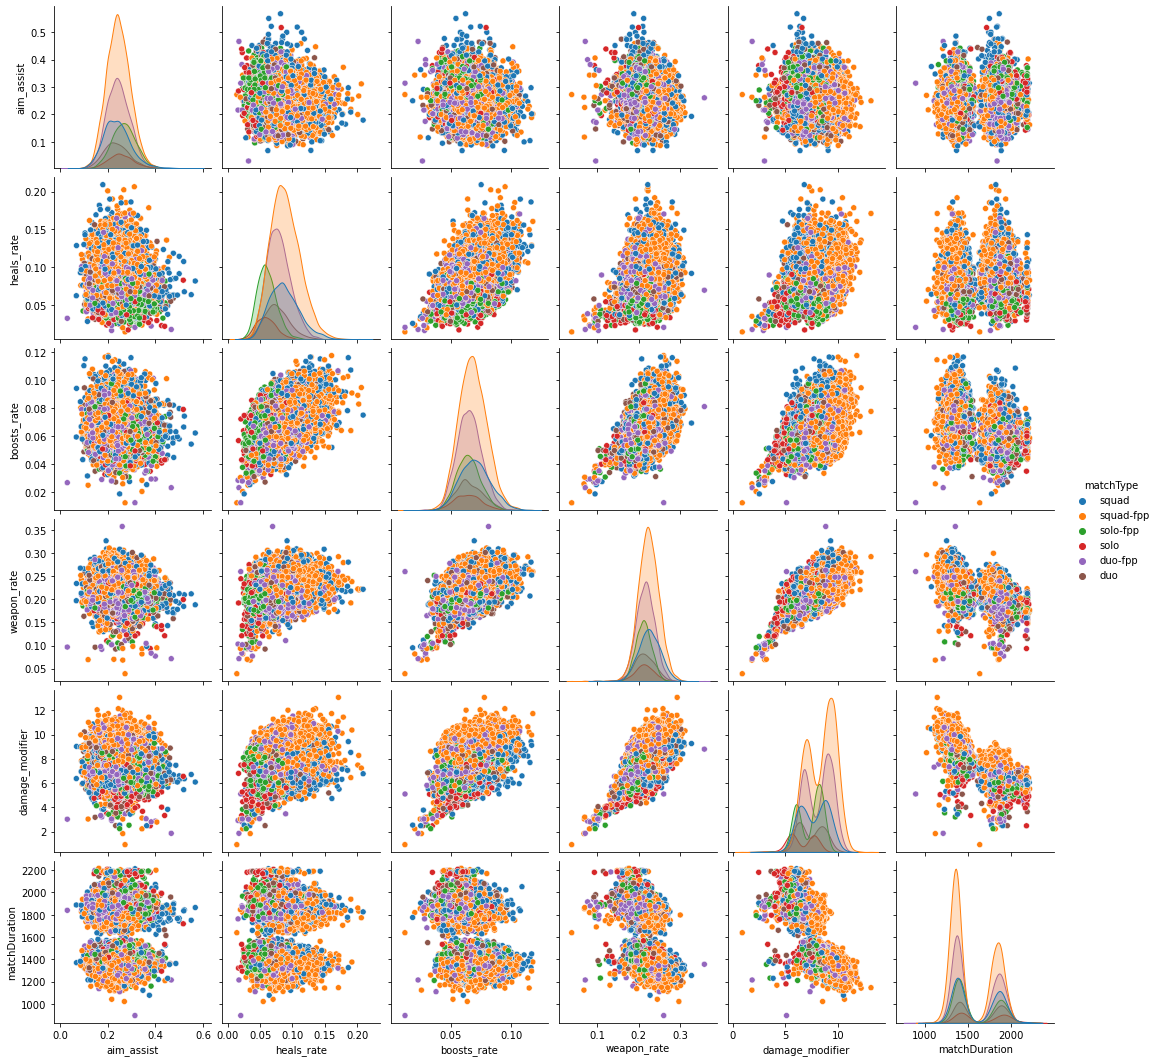

In [9]:
import seaborn as sns

sns.pairplot(match_data[potential_treatments+['matchDuration', 'matchType']], hue ='matchType')

In [10]:
# standardize treatment variables to allow for direct comparison
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
match_data[potential_treatments] = scaler.fit_transform(match_data[potential_treatments])

## Causal Analysis

In [11]:
import dowhy
import dowhy.api
from dowhy import CausalModel

### Create Model

In [12]:
# I. Create causal models

outcome = 'matchDuration'

treatment_models = {}

for treatment in potential_treatments:
    
    common_causes = [col for col in match_data if col not in [outcome, treatment]]

    model= CausalModel(
        data=match_data,
        treatment= treatment,
        outcome=outcome,
        common_causes=common_causes
    )
    
    treatment_models[treatment] = model

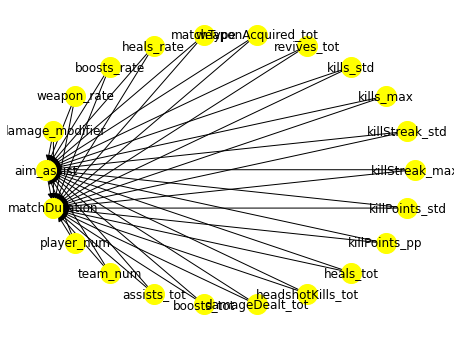

In [13]:
treatment_models['aim_assist'].view_model('dots') # Using aim assist as an illustrative example

### Idenify Causal Effect and Target Estimand

In [14]:
# II. Identify causal effect and return target estimands

identified_estimands = {}

for treatment in potential_treatments:
    identified_estimand = treatment_models[treatment].identify_effect(proceed_when_unidentifiable=True)
    identified_estimands[treatment] = identified_estimand

In [15]:
print(identified_estimands['aim_assist']) # Using aim assist as an illustrative example

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(matchDuration|heals_tot,team_num,killPoints_std,kills
d[aimₐₛₛᵢₛₜ]                                                                  

                                                                              
_std,killPoints_pp,boosts_tot,killStreak_max,kills_max,boosts_rate,heals_rate,
                                                                              

                                                                              
headshotKills_tot,assists_tot,killStreak_std,weapon_rate,matchType,weaponAcqui
                                                                              

                                                                
red_tot,revives_tot,damage_modifier,damageDealt_tot,player_num))
                                                            

### Calculate target estimand (ATE)

In [16]:
# III. Estimate the target estimand using a statistical method.

estimates = {}
results = pd.DataFrame(index=potential_treatments)

for treatment in potential_treatments:
    estimate = treatment_models[treatment].estimate_effect(
        identified_estimands[treatment],
        method_name="backdoor.linear_regression"
    )
    
    estimates[treatment] = estimate
    
    results.loc[treatment, 'cate'] = estimate.value
    cf =  estimate.get_confidence_intervals(confidence_level=0.95)
    results.loc[treatment, 'cate_err'] = (cf[0,1]-cf[0,0])/2
    

In [17]:
results

,cate,cate_err
aim_assist,3.826416,2.232168
heals_rate,28.657761,2.922245
boosts_rate,-46.928450,2.958403
weapon_rate,-109.844860,2.667645
damage_modifier,-79.368806,3.938391


<ErrorbarContainer object of 3 artists>

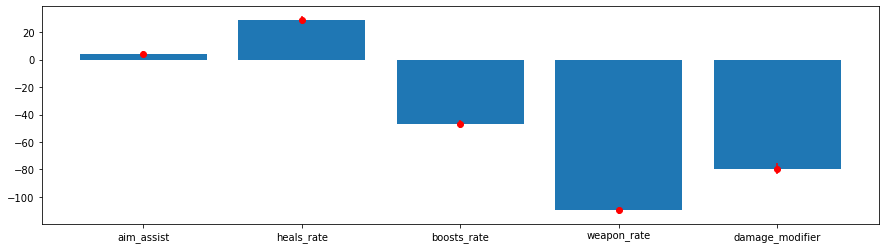

In [18]:
# Compare plot results
import matplotlib.pyplot as plt

plt.figure().set_figwidth(15)
plt.bar(results.index, results.cate)
plt.errorbar(results.index, results.cate, yerr= results.cate_err, fmt="o", color="r")

**Iterpretation**

Based on the causal model and linear causal assumption, we are able to estimate the average treatment effect (ATE) of each of the 5 identified potential treatments. Most treatments exhibit the initially intended effect, e.g. increasing damage modifier has a negtive ATE on match duration. However, aim assist and boost rate seem to defy initial expectations.

Aim assist has a small but significant positive ATE, implying that increasing aim assist would slightly increase match duration. This is surprising as increasing game assist should lead to increased damage output from players during scurmishes and faster kills. One possible explanation is that as encounter become less reliant on aiming ability the chance of success depends more heavily on tactical advantages, influencing player behaviour to be more deliberate, calculated, and therefore time consuming. More data points on player behaviour are required to support this claim as it is currently an unobserved factor.

Increasing the drop rate of boost items on the other hand has a relatively large and significant negative ATE on match duration. This is surprising as boost items offer healing effects similar to healing items, which have a positive ATE as expected. The key difference is that boost items heal at a slower rate over a longer duration while healing items heal instantly. Boost items also provide a modest bump in player movement speed in some cases. 

An increased abudance of boost items may have a greater percieved advantage due to the increased movement speed, influencing player strategy to take a more dirct route and press the advantage within the boost item's limited effect period. At the same time boost items don't provide the same survivability advantage leading to more frequent fatal encounters between players and a lower match duration.

Of the analyzed treatment effects, increasing the weapon drop rate has the highest ATE with an estimated decrease of 109 seconds per match when increasing drop rate by one standard deviation. Based on this analysis, incrasing the weapon drop rate is likely to yield the best result with miniml variation from current PUBG design parameters. However, to assert this with more confidence we preform a few refutation tests that challenge the validity of our model.

### Refuting Estimates

#### Random Common Cause Method

In this refutation approach a random independent variable is added as a common cause and the estimated effect is recalculated. A significant change the estimaed effect indicates that the initial set of common cause variables and resulting causal model are not significant/accurate representations of the causal relationship.

In [19]:
for treatment in potential_treatments:
    refute1_results=treatment_models[treatment].refute_estimate(identified_estimands[treatment], estimates[treatment],
            method_name="random_common_cause")
    results.loc[treatment, "random_common_cause"]=refute1_results.new_effect

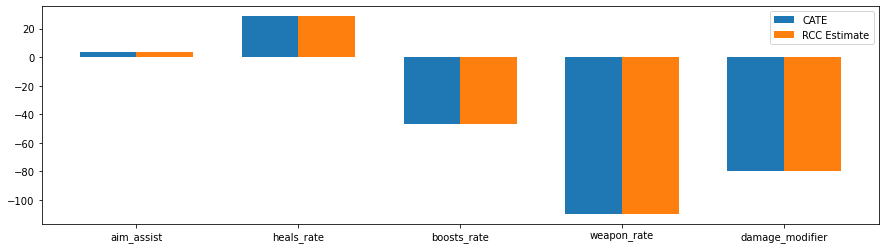

In [20]:
import numpy as np

fig, ax = plt.subplots()
fig.set_figwidth(15)

x = np.arange(len(results.index))
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, results.cate, width, label='CATE')
rects2 = ax.bar(x + width/2, results.random_common_cause, width, label='RCC Estimate')

ax.set_xticks(x)
ax.set_xticklabels(results.index)
ax.legend()

**Interpretation**

The causal model passes the random common cause refutation, no sign of lack of validity at this stage

#### Placebo Treatment Method

In this refutation approach the treatment variable is replace with an independent random variable and causal effect recalculated. Given an unbiased causal model the calculated causal effect should be very small as the placebo should not have any impact on outcome.

In [21]:
for treatment in potential_treatments:
    refute2_results=treatment_models[treatment].refute_estimate(identified_estimands[treatment], estimates[treatment],
            method_name="placebo_treatment_refuter")
    results.loc[treatment, "placebo_treatment_refuter"]=refute2_results.new_effect

<BarContainer object of 5 artists>

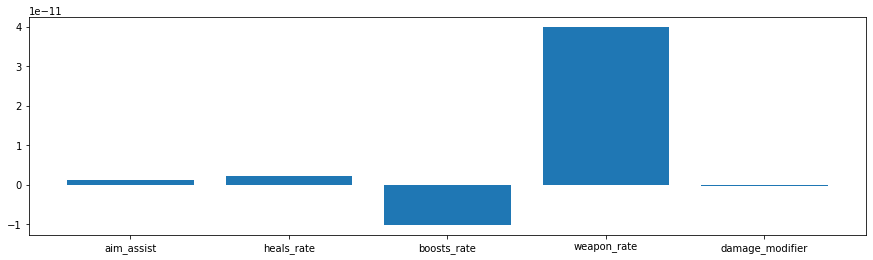

In [22]:
plt.figure().set_figwidth(15)
plt.bar(results.index, results.placebo_treatment_refuter)

**Interpretation**

All the newly calculated effects are in the 1e-11 order of magnitude, as expected given the placebo treatment. The cause model passes this refutation.

#### Data Subset Refuter

The data subset refuter replaces the given dataset with a randomly selected subset and recalculated the estimated effect. A significant change in effect indicates a high level of sensitivity in the causal model.

In [23]:
for treatment in potential_treatments:
    refute3_results=treatment_models[treatment].refute_estimate(identified_estimands[treatment], estimates[treatment],
            method_name="data_subset_refuter")
    results.loc[treatment, "data_subset_refuter"]=refute3_results.new_effect

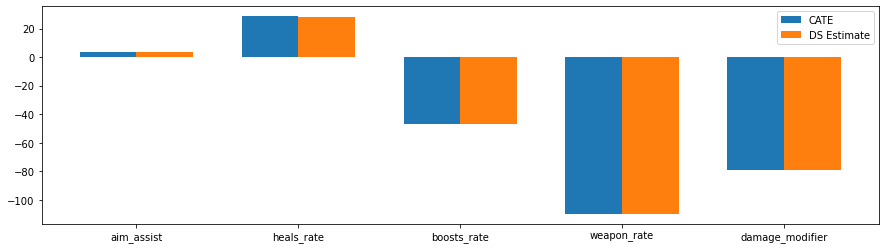

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

x = np.arange(len(results.index))
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, results.cate, width, label='CATE')
rects2 = ax.bar(x + width/2, results.data_subset_refuter, width, label='DS Estimate')

ax.set_xticks(x)
ax.set_xticklabels(results.index)
ax.legend()

In [25]:
results

,cate,cate_err,random_common_cause,placebo_treatment_refuter,data_subset_refuter
aim_assist,3.826416,2.232168,3.826102,1.136868e-12,3.601940
heals_rate,28.657761,2.922245,28.656021,2.046363e-12,28.452288
boosts_rate,-46.928450,2.958403,-46.928373,-1.023182e-11,-46.917349
weapon_rate,-109.844860,2.667645,-109.843497,3.979039e-11,-109.930497
damage_modifier,-79.368806,3.938391,-79.369890,-4.547474e-13,-79.368318


**Interpretation**

Again we see no significant changes in the estimated effect, the model passes the data subset refutation.

### Conclusion

Based on the causal analysis preformed on historical game data, our reccomendation to the PUBG mobile game designer is to focus on increasing the weapon drop rate in order to decrease match duration. Due to the linear assumption in the ATE calculation, we reccomend A/B testing different values of weapon drop rate, both in the mobile beta test and the live the PC and console versions, and evaluate the potential of diminishing in returns past a threhshold.

We also reccommend the data acquistion of more in-game data montoring player behaviour, spcifically player strategic aggression and tactical preference to inhance the causal and perform a deeper analysis on the unexpected effects of varying the boost item drop rate and aim assist.